# 2D trajectories of trees

## 1 Setup

First, setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Then import all we need for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import seaborn as sb
from sklearn.manifold import MDS

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip our models with useful tools

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Multi-dimensional scale a tree

Now add the multi-dimensional scaling tools

In [5]:
@memoized
def similarities(self, distance_type, with_spam):
    if distance_type not in Sentence.DISTANCE_TYPES:
        raise ValueError(("Unkown distance type "
                          "(not one of {}): {}").format(distance_type, Sentence.DISTANCE_TYPES))
    distance_name = distance_type + '_distance'

    # Compute similarities matrix
    sentences = self.sentences.with_spam(with_spam).all()
    size = len(sentences)
    similarities = np.zeros((size, size))
    indices = {}
    for i, s1 in enumerate(sentences):
        if s1.id not in indices:
            indices[s1.id] = i
        for j, s2 in enumerate(sentences):
            similarities[i, j] = getattr(s1, distance_name)(s2)
    
    # Check we saw all the indices go past
    assert len(indices) == size
    
    return (similarities, indices)

@memoized
def scaling(self, distance_type, with_spam, is_metric, init=None):
    # Compute similarities
    similarities, indices = self.similarities(distance_type, with_spam)
    
    # Compute scaling
    if init is None:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000,
                  dissimilarity='precomputed', n_jobs=-2)
        pos = mds.fit_transform(similarities)
    else:
        mds = MDS(n_components=2, metric=is_metric, max_iter=3000,
                  dissimilarity='precomputed', n_jobs=-2, n_init=1)
        pos = mds.fit_transform(similarities, init=init)
    
    return (pos, mds.stress_, indices)

Tree.similarities = similarities
Tree.scaling = scaling

And define our plotting function

In [6]:
def scaled_plot(self, ax, distance_type, is_metric, init=None, with_spam=False):
    pos, stress, indices = self.scaling(distance_type, with_spam, is_metric, init)
    
    # Get sentences and leaves
    sentences = self.sentences.with_spam(with_spam).all()
    size = len(sentences)
    leaves = set([s for s in sentences if s.children.with_spam(with_spam).count() == 0])
    
    # Define colors
    heads_indices = {}
    for i, head in enumerate(self.root.children.with_spam(with_spam).all()):
        heads_indices[head.id] = i
    cmap, palette = mpl_palette(len(heads_indices))
    
    # Plot sentences
    leaves_indices = [indices[leaf.id] for leaf in leaves]
    colors = np.array([(.5, .5, .5, 1)] * size)
    colors[indices[self.root.id]] = (1, 0, 0, 1)
    colors[leaves_indices] = [palette[heads_indices[leaf.head.id]] for leaf in leaves]
    sizes = np.ones(size) * 50
    sizes[indices[self.root.id]] = 200
    sizes[leaves_indices] = 200
    ax.scatter(pos[:, 0], pos[:, 1], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    links = [[s, child]
             for s in sentences
             for child in s.children.with_spam(with_spam).all()]
    segments = [[pos[indices[s.id], :], pos[indices[child.id], :]] for (s, child) in links]
    colors = np.array([heads_indices[child.head.id] for (_, child) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=cmap,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    return (pos, stress)

Tree.scaled_plot = scaled_plot

## 3 Get some actual results

### 3.1 Spammed and unspammed stresses

Hopefully unspamming the trees reduces the final stress of our downscalings.

In [7]:
trees = Tree.objects.experiment.all()
stresses_spam = np.zeros_like(trees)
stresses = np.zeros_like(trees)
print
print('Computing...', end='')
for i, tree in enumerate(trees):
    print(' #{}'.format(tree.id), end='')
    stresses_spam[i] = tree.scaling('ordered_content', True, True)[1]
    stresses[i] = tree.scaling('ordered_content', False, True)[1]

Computing... #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #20 #22 #23 #25 #26 #27 #28 #29 #30 #31 #32 #33 #34 #36 #37 #38 #39 #40 #41 #42 #43 #44 #45 #46 #47 #48 #49 #50 #51 #52 #53 #54

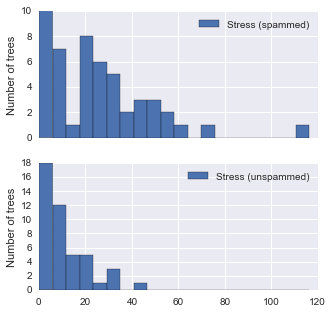

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
bins = axes[0].hist(stresses_spam, 20, label='Stress (spammed)')[1]
axes[0].set_ylabel('Number of trees')
axes[0].legend(loc='best')
axes[1].hist(stresses, bins=bins, label='Stress (unspammed)')
axes[1].set_ylabel('Number of trees')
axes[1].legend(loc='best');

### 3.2 Tree evolutions (despammed)

Computing... #11 #53 #6 #8 #13 #34 #1 #2 #7 #10 #27 #31 #33 #5 #12 #16 #18 #23 #29 #30 #41 #25 #28 #43 #3 #32 #4 #9 #36 #15 #22 #26 #50 #14 #38 #17 #54 #20 #40 #44 #39 #45 #48 #37 #42 #51 #47 #52 #46 #49

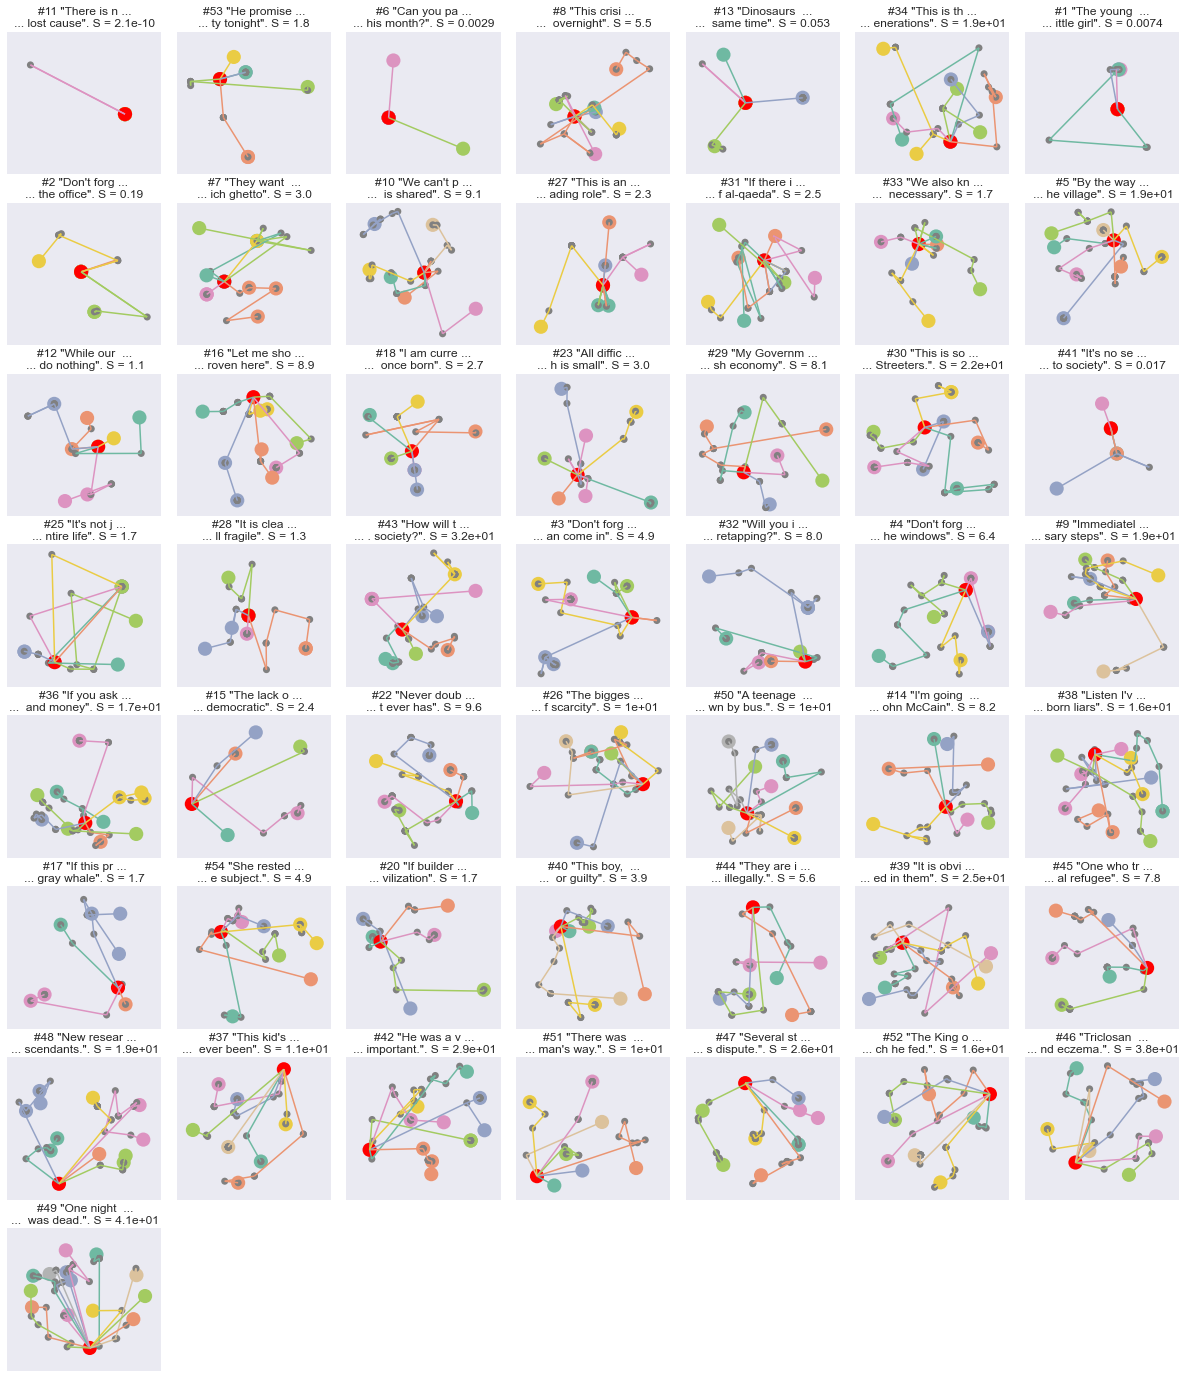

In [19]:
# Parameters
trees = Tree.objects.experiment.all()
n_cols = 7

# Ordering
trees = sorted(trees, key=lambda tree: (len(tree.root.content_words), tree.id))

# Plot
n_rows = int(np.ceil(len(trees) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
print('Computing...', end='')
for i, trees_line in enumerate(grouper(trees, n_cols)):
    for j, tree in enumerate(trees_line):
        if tree is None:
            break
        
        print(' #{}'.format(tree.id), end='')

        text = tree.root.text
        if len(text) > 25:
            text = text[:10] + ' ...\n... ' + text[-10:]
        stress = tree.scaled_plot(axes.flat[i * n_cols + j], 'ordered_content',
                                  True)[1]
        axes.flat[i * n_cols + j].set_title('#{} "{}". S = {:.2}'.format(tree.id, text, stress))
        axes.flat[i * n_cols + j].set_xticks([])
        axes.flat[i * n_cols + j].set_yticks([])

for k in range(i * n_cols + j, n_cols * n_rows):
    axes.flat[k].set_axis_off()
fig.subplots_adjust(wspace=.1, hspace=.2)